In [1]:
import tensorflow as tf
import pandas as pd
tf.__version__

'2.0.0'

This document is adapted from the paper Cost-based Modeling and Evaluation for Data Mining With Application to Fraud and Intrusion Detection: Results from the JAM Project by Salvatore J. Stolfo, Wei Fan, Wenke Lee, Andreas Prodromidis, and Philip K. Chan.
 
 
#### INTRUSION DETECTOR LEARNING
Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders.  The intrusion detector learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between ``bad'' connections, called intrusions or attacks, and ``good'' normal connections.

The 1998 DARPA Intrusion Detection Evaluation Program was prepared and managed by MIT Lincoln Labs. The objective was to survey and evaluate research in intrusion detection.  A standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment, was provided.  The 1999 KDD intrusion detection contest uses a version of this dataset.

Lincoln Labs set up an environment to acquire nine weeks of raw TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN.  They operated the LAN as if it were a true Air Force environment, but peppered it with multiple attacks.

The raw training data was about four gigabytes of compressed binary TCP dump data from seven weeks of network traffic.  This was processed into about five million connection records.  Similarly, the two weeks of test data yielded around two million connection records.

A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol.  Each connection is labeled as either normal, or as an attack, with exactly one specific attack type.  Each connection record consists of about 100 bytes.

Attacks fall into four main categories:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.

It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data.  This makes the task more realistic.  Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants.  The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.
 
 
#### DERIVED FEATURES
Stolfo et al. defined higher-level features that help in distinguishing normal connections from attacks.  There are several categories of derived features.

The ``same host'' features examine only the connections in the past two seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc.

The similar ``same service'' features examine only the connections in the past two seconds that have the same service as the current connection.

"Same host" and "same service" features are together called  time-based traffic features of the connection records.

Some probing attacks scan the hosts (or ports) using a much larger time interval than two seconds, for example once per minute.  Therefore, connection records were also sorted by destination host, and features were constructed using a window of 100 connections to the same host instead of a time window.  This yields a set of so-called host-based traffic features.

Unlike most of the DOS and probing attacks, there appear to be no sequential patterns that are frequent in records of R2L and U2R attacks. This is because the DOS and probing attacks involve many connections to some host(s) in a very short period of time, but the R2L and U2R attacks are embedded in the data portions
of packets, and normally involve only a single connection.

Useful algorithms for mining the unstructured data portions of packets automatically are an open research question.  Stolfo et al. used domain knowledge to add features that look for suspicious behavior in the data portions, such as the number of failed login attempts.  These features are called ``content'' features.

A complete listing of the set of features defined for the connection records is given in the three tables below.  The data schema of the contest dataset is available in machine-readable form .
 
 
feature name 	description  	type
duration  	length (number of seconds) of the connection  	continuous
protocol_type  	type of the protocol, e.g. tcp, udp, etc.  	discrete
service  	network service on the destination, e.g., http, telnet, etc.  	discrete
src_bytes  	number of data bytes from source to destination  	continuous
dst_bytes  	number of data bytes from destination to source  	continuous
flag  	normal or error status of the connection  	discrete 
land  	1 if connection is from/to the same host/port; 0 otherwise  	discrete
wrong_fragment  	number of ``wrong'' fragments  	continuous
urgent  	number of urgent packets  	continuous
 
Table 1: Basic features of individual TCP connections.
 
feature name 	description  	type
hot  	number of ``hot'' indicators 	continuous
num_failed_logins  	number of failed login attempts  	continuous
logged_in  	1 if successfully logged in; 0 otherwise  	discrete
num_compromised  	number of ``compromised'' conditions  	continuous
root_shell  	1 if root shell is obtained; 0 otherwise  	discrete
su_attempted  	1 if ``su root'' command attempted; 0 otherwise  	discrete
num_root  	number of ``root'' accesses  	continuous
num_file_creations  	number of file creation operations  	continuous
num_shells  	number of shell prompts  	continuous
num_access_files  	number of operations on access control files  	continuous
num_outbound_cmds 	number of outbound commands in an ftp session  	continuous
is_hot_login  	1 if the login belongs to the ``hot'' list; 0 otherwise  	discrete
is_guest_login  	1 if the login is a ``guest''login; 0 otherwise  	discrete
 
Table 2: Content features within a connection suggested by domain knowledge.
 
feature name 	description  	type
count  	number of connections to the same host as the current connection in the past two seconds  	continuous
	Note: The following  features refer to these same-host connections. 	
serror_rate  	% of connections that have ``SYN'' errors  	continuous
rerror_rate  	% of connections that have ``REJ'' errors  	continuous
same_srv_rate  	% of connections to the same service  	continuous
diff_srv_rate  	% of connections to different services  	continuous
srv_count  	number of connections to the same service as the current connection in the past two seconds  	continuous
	Note: The following features refer to these same-service connections. 	
srv_serror_rate  	% of connections that have ``SYN'' errors  	continuous
srv_rerror_rate  	% of connections that have ``REJ'' errors  	continuous
srv_diff_host_rate  	% of connections to different hosts  	continuous 
 
Table 3: Traffic features computed using a two-second time window.
  

In [2]:
attack_types, *features = open('../materials/features.txt').readlines()
attack_types = attack_types.split(',')
attack_types[-1] = attack_types[-1][:-3]
features_types_dict = {f.split(':')[0]: f.split(':')[1][1:-2] for f in features}
features = list(features_types_dict.keys())
features_types_dict['dst_host_srv_rerror_rate'] = 'continuous'
features_types_dict

{'duration': 'continuous',
 'protocol_type': 'symbolic',
 'service': 'symbolic',
 'flag': 'symbolic',
 'src_bytes': 'continuous',
 'dst_bytes': 'continuous',
 'land': 'symbolic',
 'wrong_fragment': 'continuous',
 'urgent': 'continuous',
 'hot': 'continuous',
 'num_failed_logins': 'continuous',
 'logged_in': 'symbolic',
 'num_compromised': 'continuous',
 'root_shell': 'continuous',
 'su_attempted': 'continuous',
 'num_root': 'continuous',
 'num_file_creations': 'continuous',
 'num_shells': 'continuous',
 'num_access_files': 'continuous',
 'num_outbound_cmds': 'continuous',
 'is_host_login': 'symbolic',
 'is_guest_login': 'symbolic',
 'count': 'continuous',
 'srv_count': 'continuous',
 'serror_rate': 'continuous',
 'srv_serror_rate': 'continuous',
 'rerror_rate': 'continuous',
 'srv_rerror_rate': 'continuous',
 'same_srv_rate': 'continuous',
 'diff_srv_rate': 'continuous',
 'srv_diff_host_rate': 'continuous',
 'dst_host_count': 'continuous',
 'dst_host_srv_count': 'continuous',
 'dst_hos

In [3]:
buf = """normal normal
back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l"""
buf = buf.split('\n')
target_classes = {
    'normal': 0,
    'u2r': 1,
    'r2l': 2,
    'probe': 3,
    'dos': 4
}
attack_types_dict = {line.split()[0]: line.split()[1] for line in buf}
attack_types_dict

{'normal': 'normal',
 'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l'}

In [4]:
FILE_PATH = '../materials/kddcup.data.corrected'
df = pd.read_csv(FILE_PATH, header=None)

In [5]:
df[41] = [i[:-1] for i in df[41].values]

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


In [7]:
for i in (1, 2, 3, 41):    
    print(df[i].value_counts(), end='\n\n')
    print(list(dict(df[i].value_counts()).keys()))

icmp    2833545
tcp     1870598
udp      194288
Name: 1, dtype: int64

['icmp', 'tcp', 'udp']
ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
harvest            2
http_8001          2
aol                2
http_2784          1
Name: 2, Length: 70, dtype: int64

['ecr_i', 'private', 'http', 'smtp', 'other', 'domain_u', 'ftp_data', 'eco_i', 'finger', 'urp_i', 'ftp', 'telnet', 'ntp_u', 'auth', 'pop_3', 'time', 'domain', 'Z39_50', 'gopher', 'mtp', 'ssh', 'remote_job', 'whois', 'rje', 'link', 'imap4', 'ctf', 'name', 'supdup', 'nntp', 'echo', 'discard', 'uucp_path', 'systat', 'daytime', 'netstat', 'sunrpc', 'pop_2', 'netbios_ssn', 'netbios_ns', 'vmnet', 'netbios_dgm', 'sql_net', 'iso_tsap', 'csnet_ns', 'shell', 'hostnames', 'klogin', 'bgp', 'login', 'exec', 'printer', 'http_443', 'efs', 'uucp', 'ldap', 'kshell', 'nnsp', 'courier', 'IRC', 'urh_i', 'X11', 'tim_i', 'red_i', 'pm_dump', 'tftp_u', 'ha

In [8]:
def replace(x):
    return classes[x]
for i in (1, 2, 3):
    classes_list = list(dict(df[i].value_counts()).keys())
    classes = {c: i for i, c in enumerate(classes_list)}
    df[i] = df[i].apply(replace)
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,1,2,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,1,2,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,1,2,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,1,2,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,1,2,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,1,2,0,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,1,2,0,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,1,2,0,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,1,2,0,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


In [9]:
def replace(x):
    return target_classes[attack_types_dict[x]]
df[41] = df[41].apply(replace)
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,1,2,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0
1,0,1,2,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0
2,0,1,2,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,0
3,0,1,2,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,0
4,0,1,2,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,1,2,0,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,0
4898427,0,1,2,0,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,0
4898428,0,1,2,0,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,0
4898429,0,1,2,0,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,0


In [10]:
for i, f in enumerate(features_types_dict):
    print('%02d. %010s %s' % (i, features_types_dict[f], f))

00. continuous duration
01.   symbolic protocol_type
02.   symbolic service
03.   symbolic flag
04. continuous src_bytes
05. continuous dst_bytes
06.   symbolic land
07. continuous wrong_fragment
08. continuous urgent
09. continuous hot
10. continuous num_failed_logins
11.   symbolic logged_in
12. continuous num_compromised
13. continuous root_shell
14. continuous su_attempted
15. continuous num_root
16. continuous num_file_creations
17. continuous num_shells
18. continuous num_access_files
19. continuous num_outbound_cmds
20.   symbolic is_host_login
21.   symbolic is_guest_login
22. continuous count
23. continuous srv_count
24. continuous serror_rate
25. continuous srv_serror_rate
26. continuous rerror_rate
27. continuous srv_rerror_rate
28. continuous same_srv_rate
29. continuous diff_srv_rate
30. continuous srv_diff_host_rate
31. continuous dst_host_count
32. continuous dst_host_srv_count
33. continuous dst_host_same_srv_rate
34. continuous dst_host_diff_srv_rate
35. continuous dst

In [11]:
from datetime import datetime
for i in range(42):
    start_time = datetime.now()
    max_ = df[i].max()
    print(i, ': ', max_)

0 :  58329
1 :  2
2 :  69
3 :  10
4 :  1379963888
5 :  1309937401
6 :  1
7 :  3
8 :  14
9 :  77
10 :  5
11 :  1
12 :  7479
13 :  1
14 :  2
15 :  7468
16 :  43
17 :  2
18 :  9
19 :  0
20 :  1
21 :  1
22 :  511
23 :  511
24 :  1.0
25 :  1.0
26 :  1.0
27 :  1.0
28 :  1.0
29 :  1.0
30 :  1.0
31 :  255
32 :  255
33 :  1.0
34 :  1.0
35 :  1.0
36 :  1.0
37 :  1.0
38 :  1.0
39 :  1.0
40 :  1.0
41 :  4


In [12]:
for i in (0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32):
    start_time = datetime.now()
    max_ = df[i].max()
    df[i] = df[i].apply(lambda x: x / max_)
    print(i, ': ', datetime.now() - start_time)
df

0 :  0:00:00.941047
4 :  0:00:01.029778
5 :  0:00:00.925249
7 :  0:00:00.903831
8 :  0:00:00.905484
9 :  0:00:00.885850
12 :  0:00:00.843569
13 :  0:00:00.881903
14 :  0:00:00.844450
15 :  0:00:00.904410
16 :  0:00:00.841023
17 :  0:00:00.913238
18 :  0:00:00.840615
22 :  0:00:00.997398
31 :  0:00:00.821453
32 :  0:00:00.845169


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.0,1,2,0,1.558012e-07,3.441080e-05,0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0
1,0.0,1,2,0,1.173944e-07,3.456654e-06,0,0.0,0.0,0.0,...,0.003922,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0
2,0.0,1,2,0,1.710190e-07,9.374494e-07,0,0.0,0.0,0.0,...,0.007843,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,0
3,0.0,1,2,0,1.688450e-07,1.551219e-06,0,0.0,0.0,0.0,...,0.011765,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,0
4,0.0,1,2,0,1.731929e-07,3.710101e-07,0,0.0,0.0,0.0,...,0.015686,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0.0,1,2,0,1.536272e-07,1.746648e-06,0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,0
4898427,0.0,1,2,0,1.586998e-07,1.801613e-07,0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,0
4898428,0.0,1,2,0,1.579751e-07,2.755857e-06,0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,0
4898429,0.0,1,2,0,1.586998e-07,9.420297e-07,0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,0


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
df = df.sample(frac=1)
test_df = df[:489843]
val_df = df[489843:489843+489843]
df = df[489843+489843:]

In [15]:
df[:489843]

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
1666420,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
4134314,0.0,0,0,0,3.768215e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
1798677,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
2952971,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
2545510,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636194,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
898254,0.0,1,4,2,0.000000e+00,0.0,0,0.0,0.0,0.0,...,0.003922,0.00,1.00,0.0,0.0,0.0,0.0,1.0,1.0,3
4833440,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4
937170,0.0,0,0,0,7.478457e-07,0.0,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,4


In [16]:
target = df.pop(41)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [18]:
val_target = val_df.pop(41)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df.values, val_target.values))

In [19]:
for feat, targ in dataset.take(5):
  print ('Признаки: {}, Цель: {}'.format(feat, targ))

Признаки: [ 0.          1.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.53228963 15.
  1.          1.          0.          0.          0.06        0.06
  0.          1.          0.02352941  0.02        0.07        0.
  0.          1.          1.          0.          0.        ], Цель: 4
Признаки: [ 0.          1.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.27005871 17.
  1.          1.          0.          0.          0.12        0.06
  0.          1.          0.06666667  0.07        0.06        0.
  0.          1.          1.          0.          0.        ], Цель: 4
Признаки: [0.00000000e+00 0.00000000e+00 0.00000000e+0

In [19]:
BATCH_SIZE = 64
train_dataset = dataset.shuffle(len(df)).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(len(val_df)).batch(BATCH_SIZE)

In [29]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(41, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [33]:
import numpy as np
model = get_compiled_model()
epochs = 40
history = model.fit_generator(
    train_dataset,
    steps_per_epoch=int(np.ceil(len(df) / (epochs * float(BATCH_SIZE)))) - 2,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=int(np.ceil(len(val_df) / (epochs * float(BATCH_SIZE)))) - 2
)

Epoch 1/40
1529/1529 [==============================] - 16s 11ms/step - loss: 0.1528 - accuracy: 0.9342 - val_loss: 0.0081 - val_accuracy: 0.9982
Epoch 2/40
1529/1529 [==============================] - 12s 8ms/step - loss: 0.0227 - accuracy: 0.9971 - val_loss: 0.0127 - val_accuracy: 0.9975
Epoch 3/40
1529/1529 [==============================] - 12s 8ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.0086 - val_accuracy: 0.9984
Epoch 4/40
1529/1529 [==============================] - 12s 8ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 0.1090 - val_accuracy: 0.9818
Epoch 5/40
1529/1529 [==============================] - 12s 8ms/step - loss: 0.0506 - accuracy: 0.9882 - val_loss: 0.0067 - val_accuracy: 0.9984
Epoch 6/40
1529/1529 [==============================] - 12s 8ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0072 - val_accuracy: 0.9987
Epoch 7/40
1529/1529 [==============================] - 12s 8ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0063 - val_a

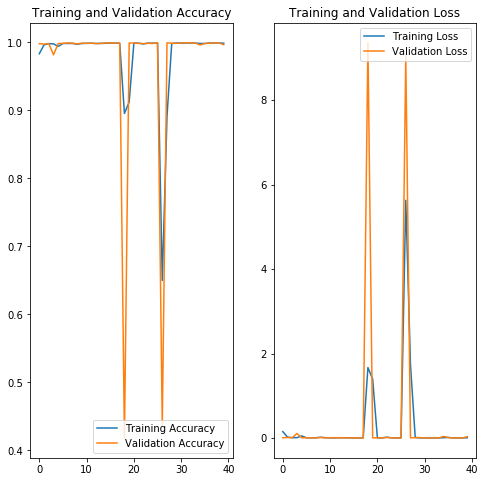

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
test_target = test_df.pop(41)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.values, test_target.values))
test_dataset = test_dataset.shuffle(len(test_df)).batch(BATCH_SIZE)

test_loss, test_accuracy = model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

7654/7654 [==============================] - 6s 839us/step - loss: 0.2083 - accuracy: 0.9973
Accuracy on test dataset: 0.99726236
